## Homework 4 (ASTR8060)
#### Niana Mohammed
#### March 24 2021

In [1]:
# importing basic packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.io.fits as fits

### 2. Finding overscan region
#### After using DS9 to open a flat frame and find the overscan region of the chip (on both sides of the data section):

####  left overscan region= [0:2048, 0:53]
####  right overscan region= [0:2048, 2101:2200]

These overscan regions are present in all our frames (biases,flats,darks,science).

To further visualize this, we can collapse the rows of a flat frame by finding the column-wise mean and plot it. 

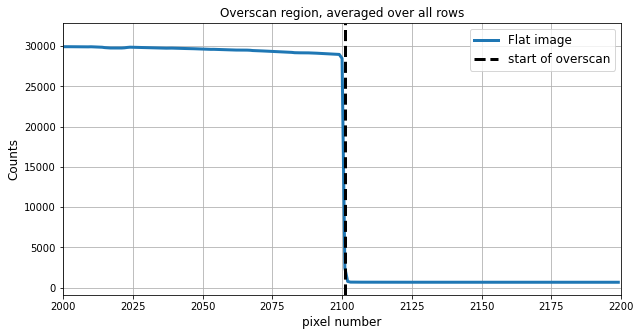

In [2]:
from astropy.nddata import CCDData

# reading in a flat frame
flat = CCDData.read("Imaging/a048.fits", unit='count')

plt.figure(figsize=(10,5))
plt.plot(flat.data.mean(axis=0),linewidth=3,label='Flat image')
plt.grid()
plt.axvline(x=2101, color='black', linewidth=3, linestyle='dashed', label='start of overscan')
plt.legend(fontsize=12)
# zoom in to just the right side overscan region
plt.xlim(2000, 2200)
plt.xlabel('pixel number',fontsize=12)
plt.ylabel('Counts',fontsize=12)
plt.title('Overscan region, averaged over all rows',fontsize=12)
plt.show()

### 3.  RMS and Mean of an image 
#### Here we plot a column of data from a bias image. Then we compute the mean and RMS near the center of the chip. 

In [3]:
# opening a bias image
fx2 = fits.open("Imaging/a100.fits")
dat2 = fx2[0].data

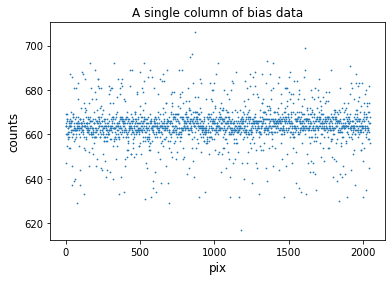

In [4]:
# selecting a single column
col=dat2[:,55]
pix = np.arange(0,2048,1)
plt.scatter(pix,col,s=0.5)
plt.xlabel("pix",fontsize=12)
plt.ylabel("counts",fontsize=12)
plt.title('A single column of bias data',fontsize=12)
plt.show()

Calculating the RMS and mean near the center of the chip.

In [5]:
# cropping out a region around the center of the chip
row = dat2.shape[0]
col = dat2.shape[1]
row_center = int(row/2)
col_center = int(col/2)
square_region = dat2[(row_center-100):(row_center+100),(col_center-100):(col_center + 100)]

# calculating mean and rms of this region
mean = np.mean(square_region)
rms = np.std(square_region)
print('mean: '+str(mean));print('rms: '+str(rms))

mean: 670.76295
rms: 8.737182457606114


### 5.  Examining how much bias and overscan levels change throughout the night. 
#### To see how much one bias frame varies from another, the mean of each bias is plotted over exposure time. The same is done for the overscan regions of the bias frames and the overscan regions of a sample of flat frames. This should help us see if and when it makes sense for the overscan region and bias frame to be used interchangeably.

In [6]:
# putting the paths of the biases (a93-a111) in a list 
bias1 = ["Imaging/a0"+str(i)+".fits" for i in np.arange(93,100,1)]
bias2 = ["Imaging/a"+str(i)+".fits" for i in np.arange(100,112,1)]
# combined list containing all bias paths
bias_list = bias1+bias2

# getting date and time from the headers
datetime = [fits.getheader(i)["DATE-OBS"] for i in bias_list]

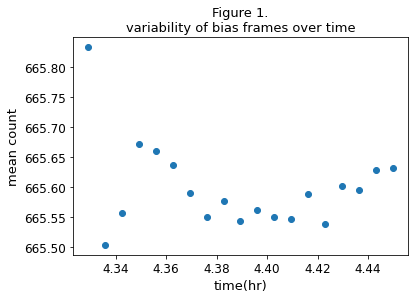

In [7]:
# remove the date part from datetime
time = [i[11:] for i in datetime]

# function to convert time to hours
def hour(time_str):
    # get time in hours
    h, m, s = time_str.split(':')
    return int(h) + int(m)/60 +int(float(s))/3600

time_hrs = [hour(i) for i in time]

# take the mean of each of the biases
bias_means = [np.mean(fits.open(file)[0].data) for file in bias_list]

plt.scatter(time_hrs,bias_means)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12) 
plt.xlabel("time(hr)",fontsize=13)
plt.ylabel("mean count",fontsize=13)
plt.title("Figure 1.\nvariability of bias frames over time",fontsize=13) 
plt.show()

#### Repeating procedure for overscan regions of bias frames and sample flat frames.

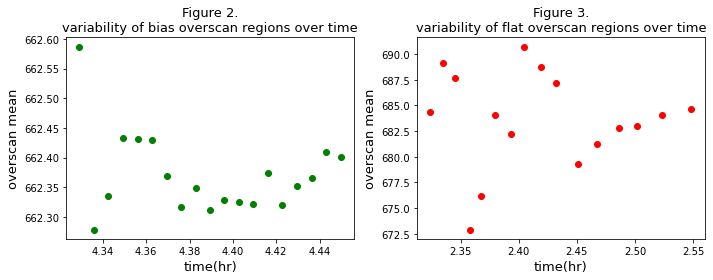

In [8]:
# grabbing flats from a040-a055
flat_list = ["Imaging/a0"+str(i)+".fits" for i in np.arange(40,56,1)]

datetime1 = [fits.getheader(i)["DATE-OBS"] for i in flat_list]
time1 = [i[11:] for i in datetime1]
time_hrs1 = [hour(i) for i in time1]

# take the mean of the right-side overscan for each of the flats
flat_data = [fits.open(file)[0].data for file in flat_list]
overscan_means = [np.mean(i[:,2101:2200]) for i in flat_data]

# repeat for overscan of each of the biases
biasdat = [fits.open(file)[0].data for file in bias_list]
over_means = [np.mean(i[:,2101:2200]) for i in biasdat]

fig, ax = plt.subplots(1,2, tight_layout=True,figsize=(10,4))
ax[0].scatter(time_hrs,over_means,c='g')
ax[0].set_xlabel("time(hr)",fontsize=13)
ax[0].set_ylabel("overscan mean",fontsize=13)
ax[0].set_title("Figure 2.\nvariability of bias overscan regions over time",fontsize=13)

ax[1].scatter(time_hrs1,overscan_means,c='r')
ax[1].set_xlabel("time(hr)",fontsize=13)
ax[1].set_ylabel("overscan mean",fontsize=13)
ax[1].set_title("Figure 3.\nvariability of flat overscan regions over time",fontsize=13)
plt.show()

Observing these three plots, the variability of the bias frames over time is not significant (Fig.1). The variability of the overscan regions in those bias frames doesn't vary much either (Fig.2). However, more variability is seen in the overscan regions of the sample flat frames (Fig.3). It makes sense that the flat overscan regions vary more, because unlike the bias frames, they were not taken in a very short amount of time in a row. The overscan region in a non-bias frames is exposed for a longer time, which is why we see it changing more over time.  
##### Note: In a bias frame, the frame is not that different from it's overscan––they are pretty much the same level, as seen in Fig.1 & 2. And since bias overscans have the same level in bias frames, it's okay to consider the two interchangeably in that context.

However, the overscan regions in other frames are not at the same level as the bias frames (Fig.3 shows that they vary a lot more), so we cannot really use overscan regions of other frames (flats, darks, science) as an estimate for the bias level in those frames. So in this context, it's better to make a master bias frame and subtract that from all the images, and separately subtract overscan regions from their corresponding frames if needed. 


### 6. Using CCDPROC.SUBTRACT_OVERSCAN and CCDPROC.TRIM_IMAGE
#### Before each image can be overscan subtracted and trimmed, we need to characterize its overscan region. To do that, we can model the overscan of each image and find its best polynomial fit. The polynomials attempted here are 'chebyshev', 'legendre', 'hermite', and 'polynomial'.

In [9]:
from astropy.modeling import models, fitting
from astropy.modeling.polynomial import Polynomial1D as poly
from astropy.modeling.polynomial import Chebyshev1D as cheb
from astropy.modeling.polynomial import Legendre1D as leg
from astropy.modeling.polynomial import Hermite1D as her

 [astropy.modeling.fitting]


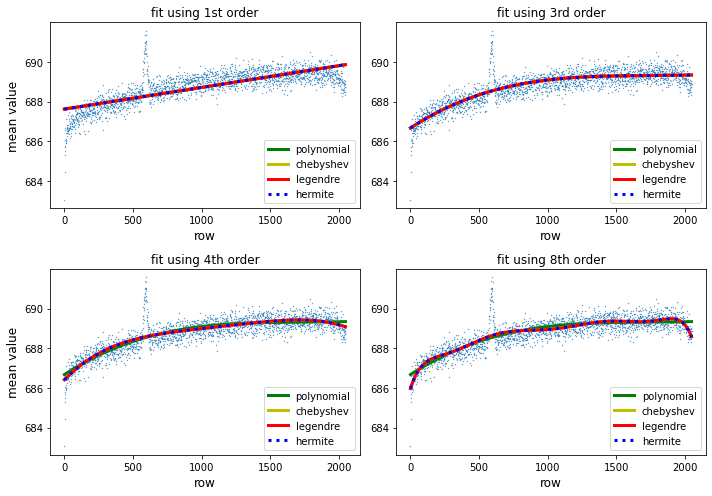

In [10]:
# choosing any flat frame to fit a model to its overscan region.
fx1 = fits.open("Imaging/a048.fits")
dat1 = fx1[0].data
overscan=dat1[:,2101:2200]

row=np.arange(0,2048,1)
# collapsing the columns of the overscan region by finding its row-wise mean
row_mean=np.mean(overscan,axis=1)

# making the models using the polynomials with varying orders
ma,mb,mc,md = poly(1),cheb(1),leg(1),her(1)
ma1,mb1,mc1,md1 = poly(3),cheb(3),leg(3),her(3)
ma2,mb2,mc2,md2 = poly(4),cheb(4),leg(4),her(4)
ma3,mb3,mc3,md3 = poly(8),cheb(8),leg(8),her(8)

# choosing linear least sq. fitter to fit the models to the data
fitter = fitting.LinearLSQFitter()
# fit the data with the different models
fita,fitb,fitc,fitd = fitter(ma,row,row_mean),fitter(mb,row,row_mean),fitter(mc,row,row_mean),fitter(md,row,row_mean)
fita1,fitb1,fitc1,fitd1 = fitter(ma1,row,row_mean),fitter(mb1,row,row_mean),fitter(mc1,row,row_mean),fitter(md1,row,row_mean)
fita2,fitb2,fitc2,fitd2 = fitter(ma2,row,row_mean),fitter(mb2,row,row_mean),fitter(mc2,row,row_mean),fitter(md2,row,row_mean)
fita3,fitb3,fitc3,fitd3 = fitter(ma3,row,row_mean),fitter(mb3,row,row_mean),fitter(mc3,row,row_mean),fitter(md3,row,row_mean)

figs, axs = plt.subplots(2,2, tight_layout=True,figsize=(10,7))
axs[0,0].plot(row,fita(row), color='g', linewidth=3, label='polynomial')
axs[0,0].plot(row,fitb(row), color='y', linewidth=3, label='chebyshev')
axs[0,0].plot(row,fitc(row), color='r', linewidth=3, label='legendre')
axs[0,0].plot(row,fitd(row), color='b', ls=':',linewidth=3, label='hermite')
axs[0,0].scatter(row,row_mean,s=0.1)
axs[0,0].set_xlabel("row",fontsize=12)
axs[0,0].set_ylabel("mean value",fontsize=12)
axs[0,0].set_title("fit using 1st order",fontsize=12)
axs[0,0].legend()

axs[0,1].plot(row,fita1(row), color='g', linewidth=3, label='polynomial')
axs[0,1].plot(row,fitb1(row), color='y', linewidth=3, label='chebyshev')
axs[0,1].plot(row,fitc1(row), color='r', linewidth=3, label='legendre')
axs[0,1].plot(row,fitd1(row), color='b', ls=':',linewidth=3, label='hermite')
axs[0,1].scatter(row,row_mean,s=0.1)
axs[0,1].set_xlabel("row",fontsize=12)
axs[0,1].set_title("fit using 3rd order",fontsize=12)
axs[0,1].legend()

axs[1,0].plot(row,fita2(row), color='g', linewidth=3, label='polynomial')
axs[1,0].plot(row,fitb2(row), color='y', linewidth=3, label='chebyshev')
axs[1,0].plot(row,fitc2(row), color='r', linewidth=3, label='legendre')
axs[1,0].plot(row,fitd2(row), color='b', ls=':',linewidth=3, label='hermite')
axs[1,0].scatter(row,row_mean,s=0.1)
axs[1,0].set_xlabel("row",fontsize=12)
axs[1,0].set_ylabel("mean value",fontsize=12)
axs[1,0].set_title("fit using 4th order")
axs[1,0].legend()

axs[1,1].plot(row,fita3(row), color='g', linewidth=3, label='polynomial')
axs[1,1].plot(row,fitb3(row), color='y', linewidth=3, label='chebyshev')
axs[1,1].plot(row,fitc3(row), color='r', linewidth=3, label='legendre')
axs[1,1].plot(row,fitd3(row), color='b', ls=':',linewidth=3, label='hermite')
axs[1,1].scatter(row,row_mean,s=0.1)
axs[1,1].set_xlabel("row",fontsize=12)
axs[1,1].set_title("fit using 8th order",fontsize=12)
axs[1,1].legend()

plt.show()

Using a lower order, such as 1st or 2nd order doesn't characterize this overscan region well enough. At 3rd order, it doesn't really matter what function we pick since they're all basically the same. It's not until we get to the 4th order that the different functions do show themselves. We don't want to go above this order because all we start to add is wiggles that aren't real. This is seen in the 8th order plot. The goal is not trying to fit every data point, but to get the general trend. Therefore, 4th order seems the lowest order possible that helps us achieve that. 

Based on the plots, 'chebyshev', 'legendre' and 'hermite' appear similar. To make a final choice for which model to use, we can find each model's residual (data minus model, i.e, the numerator of a chisq), take the $\textbf{standard deviations (RMS)}$, and use that as a metric of how good each fit is. We'll do this for 4th order.


In [11]:
pol4 = np.std(row_mean-fita2(row))
cheb4 = np.std(row_mean-fitb2(row))
leg4 = np.std(row_mean-fitc2(row))
her4 = np.std(row_mean-fitd2(row))
print('polynomial:'+str(pol4),'\nchebyshev:'+str(cheb4),'\nlegendre:'+str(leg4),'\nhermite:'+str(her4))

polynomial:0.44169265024800086 
chebyshev:0.4327975640161844 
legendre:0.4327975640161831 
hermite:0.43279756401618186


The last three orders have the smallest RMS, but are almost exactly the same. We'll settle for 4th order legendre polynomial, because legendre polynomials generally don't use any weight function to perform calculations (w(x)=1). With this polynomial, no value is weighted more to have an influence on the model's outcome.

Note: this might not be the best fit for other data––here we modeled the overscan of just a single flat image. Picking the best fit for an image/frame requires checking it both visually and quantitatively (RMS). Since it won't be effective to visually examine each image to characterize its overscan, we'll use 4th order legendre polynomial as the model for subtracting all overscans in this assignment. This model might not be the best fit for all images, but it's neither too high nor too low an order to be a 'bad' fit visually. And quantitatively, it will always give a better RMS than 'polynomial' or 'chebyshev'. 

##### The funciton below is for adding some missing headers to the flats and science frames. For the purposes of this assignment, it is not necessary to implement it. It will be needed for when we eventually have to separate the frames by filter. 
P.S. most of this assignment's code was already written by the time I decided to make this function, which is why I didn't implement it––would've had to rewrite everything otherwise.

In [12]:
# function to add headers to fits files
def add_header(filt,imgtyp,ranges=np.arange(30,40,1),prefix='a0',path='reduced/'):
    # filt & imgtyp should be strings, prefix & ranges can be changed to fit naming scheme.
    for i in ranges:
        file = fits.open('Imaging/'+prefix+str(i)+".fits")
        head = file[0].header
        head["BIASSEC"]="[0:2048,2101:2200]"
        head["TRIMSEC"]="[0:2048,53:2101]"
        head["FILTER"]=str(filt)
        head["IMAGETYP"]=str(imgtyp)
        file.writeto(path+prefix+str(i)+'r'+".fits", overwrite=True)
    return print("done")
# Eg. add_header('Halpha','SkyFlat',ranges=np.arange(11,13,1))
#     fits.open("reduced/a012r.fits")[0].header  ---to check

#### Now we can use CCDPROC.SUBTRACT_OVERSCAN to fit and subtract the overscan region of each image, and then use CCDPROC.TRIM_IMAGE to trim each image and remove the overscan region.


Notice how for each image, we subtract that image's overscan region. This is because each region is unique to it's image, and it would be wrong to have a generalized overscan region for all frames (as shown in problem 5).

In [13]:
from ccdproc import subtract_overscan
from ccdproc import trim_image
from astropy.nddata import CCDData

# making list of flat frames' paths, where saturated and bad have been excluded
flat1 = ["Imaging/a00"+str(i)+".fits" for i in np.arange(1,10,1)]
flat2 = ["Imaging/a0"+str(i)+".fits" for i in np.hstack([np.arange(10,21,1),np.arange(22,30,1),np.arange(33,56,1),np.arange(57,63,1)])]
flat_list = flat1+flat2

# list of paths to dark frames
dark1 = ["Imaging/d00"+str(i)+".fits" for i in np.arange(1,10,1)]
dark2 = ["Imaging/d0"+str(i)+".fits" for i in np.arange(10,16,1)]
dark_list = dark1+dark2

# list of science frame paths
science1 = ["Imaging/a0"+str(i)+".fits" for i in np.arange(74,93,1)]
science2= ["Imaging/a"+str(i)+".fits" for i in np.arange(130,140,1)]
science_list = science1+science2

# opening the data in ccdproc supported format.
bias_data = [CCDData(fits.open(file)[0].data, unit='count') for file in bias_list]
flat_data = [CCDData(fits.open(file)[0].data, unit='count') for file in flat_list]
dark_data = [CCDData(fits.open(file)[0].data, unit='count') for file in dark_list]
science_data = [CCDData(fits.open(file)[0].data, unit='count') for file in science_list]

# subtract each image's overscan region (right side overscan) from it
bias_scan = [subtract_overscan(bias_data[i], overscan=bias_data[i][:, 2101:2200],model=mc2) for i in range(len(bias_data))]
flat_scan = [subtract_overscan(flat_data[i], overscan=flat_data[i][:, 2101:2200],model=mc2) for i in range(len(flat_data))]
dark_scan = [subtract_overscan(dark_data[i], overscan=dark_data[i][:, 2101:2200],model=mc2) for i in range(len(dark_data))]
science_scan=[subtract_overscan(science_data[i], overscan=science_data[i][:, 2101:2200],model=mc2) for i in range(len(science_data))]

# trim each image's overscan region
biases = [trim_image(bias_scan[i][:, 53:2101]) for i in range(len(bias_scan))]
flats = [trim_image(flat_scan[i][:, 53:2101]) for i in range(len(flat_scan))]
darks = [trim_image(dark_scan[i][:, 53:2101]) for i in range(len(dark_scan))]
science = [trim_image(science_scan[i][:, 53:2101]) for i in range(len(science_scan))]

### 7. Using CCDPROC.COMBINE to make a master bias frame.
#### Before we can combine all the bias frames, we need to look at variations in the bias frames to see if there are outlier frames that could affect the mean. 
From Fig.1 in number 5, we saw that there really wasn't much variation going from one bias frame to the next––there are no trends in the sequence of bias frames. 

But we also have to check if the pattern in each bias changes throughout the night. For instance, does the position of the bright center of a bias image change from one frame to another?

To check for patterns in each bias frame, we can collapse the rows by finding the column-wise mean and plotting that against the number of columns (no. of pixels).

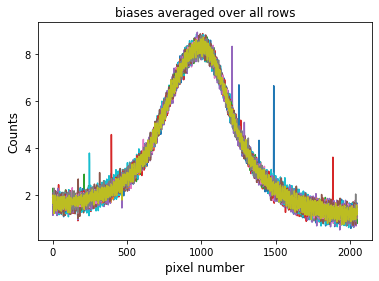

In [14]:
# loop through each bias to compute average over all rows and plot it  
for i in biases:
    plt.plot(i.data.mean(axis=0))
plt.xlabel('pixel number',fontsize=12)
plt.ylabel('Counts',fontsize=12)
plt.title('biases averaged over all rows',fontsize=12)
plt.show()

As seen in this plot, the pattern of each bias doesn't appear to be changing––no unusual trends are observed and the bright center remains in the same position. 

Therefore, it should be appropriate to combine all the bias exposures to make 1 master bias.

#### Now we can combine the bias frames into a single master bias frame.
But it would be helpful to check if it's better to use a mean or median to make the master bias frame. 
Here, we can implement ccdproc.combine to make a master frame using average and median, and then making a histogram of both to evaluate them. 

In [15]:
#using CCDPROC.COMBINE
import ccdproc
master_bias_mean = ccdproc.combine(biases, method='average')
master_bias_median = ccdproc.combine(biases, method='median')

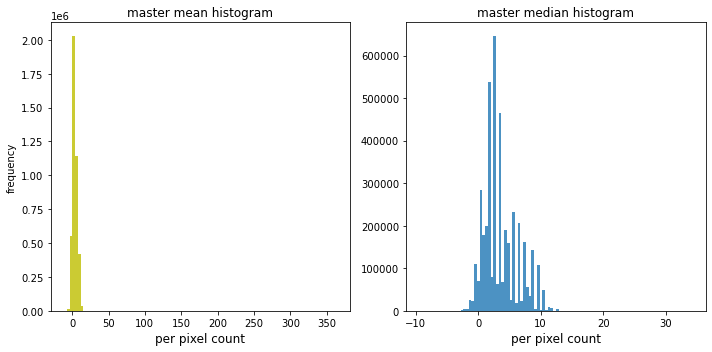

std median: 2.7259187464257404 
std mean: 3.112547033127181


In [16]:
# checking plotting doing histograms
figures, axes = plt.subplots(1,2, tight_layout=True,figsize=(10,5))
axes[1].hist(np.array(master_bias_median).flatten(),bins=100,alpha=0.8)
axes[0].hist(np.array(master_bias_mean).flatten(),color='y',bins=100,alpha=0.8)
axes[1].set_xlabel('per pixel count',fontsize=12) 
axes[0].set_xlabel('per pixel count',fontsize=12) #bin
axes[0].set_ylabel('frequency') #frequency
axes[1].set_title('master median histogram',fontsize=12)
axes[0].set_title('master mean histogram',fontsize=12)
plt.show()
# compare their standard deviations
print('std median: '+str(np.std(master_bias_median)),'\nstd mean: '+str(np.std(master_bias_mean)))

From the histograms, we can see that the mean is not doing a good job of removing outlier values (probably cosmic rays). But the median seems to do a better job of excluding those unwanted values. We can still get cosmic rays after doing a median––it's just that doing the median removed the most extreme values. Furthermore, the standard deviation of the median is smaller than the mean, as expected. 

A better method to combine the biases is discussed in problem 9, but for now we'll take the master bias to be the median. This master bias is subtracted from the science frames below. 

In [17]:
master_bias = master_bias_median

#subtracting the master bias from each of the overscan subtracted science images
sub_science = [np.subtract(i,master_bias) for i in science]

But we should check if doing a bias subtraction in addition to the overscan subtraction adds noise to the data. Finding the standard deviation of each overscan subtracted science image, and comparing that to the standard deviation after doing bias subtraction, should help us check for this.  

In [18]:
# calculate standard deviations for images before & after bias subtraction
a = [np.std(i) for i in science]
b = [np.std(i) for i in sub_science]
# print the first 5 results of each
print("before subtraction: "+str(a[0:6]));print("after subtraction: "+str(b[0:6]))

before subtraction: [122.61049770724455, 265.518906330533, 430.20919482425506, 634.3242488479639, 926.1691619148528, 1405.4784648145612]
after subtraction: [122.60044988228266, 265.5186042909189, 430.213323647421, 634.3319294964668, 926.1806946279037, 1405.4915819022915]


The standard deviation after subtraction appears to be a little less than before subtraction. So doing a bias subtraction in addition to overscan subtraction does not seem to be adding noise to the data. It should be okay to subtract the master bias from our science frames. 

### 8. Range of Dark Current
#### To estimate the range of dark current (e-/pix/s) in the darks, we could use the equation below, which relates the dark current to no. of dark electrons, exposure time, and gain (given as 2.5e-/ADU):
#####              $$d_e(t_{exp})=d_c(T)*t_{exp}/g$$
#### where $d_c(T)$ is dark current, $d_e(t_{exp})$ is no. of dark electrons in an exposure, $g$ is gain, $t_{exp}$ is exposure time, and $T$ is just temperature. For our purposes, 
#####              $$d_c(T)=d_e(t_{exp})*g/t_{exp}$$
Below, we calculate the dark currents corresponding to the pixels with min and max dark counts in each frame. Then these are compared across all frames to find the overall min and max dark current. This isn't exactly correct since some extreme values in our darks could be false (cosmic rays), and we don't remove them here. 

In [20]:
# changing the ccdproc format dark arrays into np arrays
dark_arrays = [np.array(i) for i in darks]
# find min count and max count from each frame
min_darks = [np.amin(i) for i in dark_arrays]
max_darks = [np.amax(i) for i in dark_arrays]

# get each frame's exposure time
exp_times = [fits.getheader(i)["EXPTIME"] for i in dark_list]

# calculate min and max dark current values
gain = 2.5 
min_currents = np.array(min_darks)*gain/np.array(exp_times)
max_currents = np.array(max_darks)*gain/np.array(exp_times)

# find the overall min and max dark current 
min_idx = np.where(min_currents==np.amin(min_currents))[0][0]
max_idx = np.where(max_currents==np.amax(max_currents))[0][0]

print("estimated range of dark current:\n",str([np.amin(min_currents),np.amax(max_currents)]))
print("corresponding exposure times:\n",str([exp_times[min_idx],exp_times[max_idx]]))

estimated range of dark current:
 [-36.72495205360377, 3504.998760184842]
corresponding exposure times:
 [2, 2]


Note again that this range is estimated without removing cosmic rays. Normally we'd expect more dark current to be accrued with longer exposure times. But here, the calculated max dark current ended up in a 2 sec exposure frame probably due to cosmic rays or read noise (since dark current is probably smaller than read noise in a 2 sec exposure). Therefore some of the high values in our darks, which are not actual dark counts, should be removed for a better estimate of a dark current range.

### 9. Using CCDPROC.COMBINE to make a master dark
#### Here, different combination parameters of ccdproc.combine are tested to see which one does the best job of eliminating cosmic rays. (1)A straight average of all dark frames, (2) A straight median of all dark frames, (3) An average where outlier pixels are rejected if they are more than 3σ away from the mean, and (4) A median where outlier pixels are rejected if they are more than 3σ away from the mean.


In [21]:
from astropy.stats import mad_std

# a straight average
master_dark1 = ccdproc.combine(darks, method='average')


In [22]:
# a straight median
master_dark2 = ccdproc.combine(darks, method='median')

In [23]:
# average where outlier pixels are rejected if they are more than 3σ away from the mean
master_dark3 = ccdproc.combine(darks, method='average', sigma_clip=True, 
                             sigma_clip_low_thresh=3, sigma_clip_high_thresh=3,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std)

In [24]:
# median where outlier pixels are rejected if they are more than 3σ away from the mean
master_dark4 = ccdproc.combine(darks, method='median', sigma_clip=True, 
                             sigma_clip_low_thresh=3, sigma_clip_high_thresh=3,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std)

Finding the RMS in the master image for each case should help to see which combination procedure is best.  

In [25]:
# doing rms of each case
rms1 = np.std(master_dark1)
rms2 = np.std(master_dark2)
rms3 = np.std(master_dark3)
rms4 = np.std(master_dark4)
print(rms1,rms2,rms3,rms4)

2.9761739959239875 2.7575639888466856 2.708621439187973 2.767574085959267


'rms3' gives the smallest value, therefore the third procedure (master_dark3; average combination with sigma clipping) is the best combination procedure.  

Now we want to compare the master dark to our master bias to estimate the significance of the highest dark count pixels. An important thing here is that the a bias frame has no exposure time, so it's mostly read noise (and some small fraction of hot pixels). A dark frame, on the other hand, has both dark current and read noise. So if by comparing the mean of the master bias to that of the master dark we find that the mean of the master dark is much larger, then it means that dark current did have a significant impact in that frame. In that case, we'll probably have to do a dark subtraction, and that alone can be used for dark and bias subtraction (because the dark frame has both dark current and read noise in it). 

In [26]:
print('master bias mean and rms: '+str(np.mean(master_bias))+" "+str(np.std(master_bias)))
print('master dark mean and rms: '+str(np.mean(master_dark3))+" "+str(rms3))
#compare this with result(s) from cell above

master bias mean and rms: 3.5668519475822498 2.7259187464257404
master dark mean and rms: 3.6151388266144204 2.708621439187973


It looks like the master dark mean is not that much larger the master bias mean. This means that the highest dark counts are not large enough to skew the mean significantly. It should therefore be okay to do just a bias subtraction. 

Another good test to check the significance of the dark current in this camera, is to compare the read noise to the dark current. To get a sense of what the read noise is, we can look at the standard deviation of a bias frame. And to find the typical dark current, we can use the average dark count in a dark image and its corresponding exposure time (can do this for each frame). If the dark current is much much more than the read noise, we would need to subtract it. If it's much much less, then read noise is going to dominate anyway and we could leave the dark current in the data and it won't matter. 

In [27]:
# looking at std of a bias frame to get an estimate of what the readnoise is
print('read noise: '+str(np.std(np.array(biases[18]))))

read noise: 8.855104943253131


In [28]:
# taking mean of each dark frame to estimate an average dark count in each frame
avg_counts = [np.mean(np.array(darks[i])) for i, ele in enumerate(darks)]
# finding the corresponding exposure times
exp_time = [fits.getheader(dark_list[i])["EXPTIME"] for i, ele in enumerate(darks)]
# calculating the dark currents
dark_currents = np.array(avg_counts)*gain/np.array(exp_time)
print('dark_currents: '+str(dark_currents))

dark_currents: [4.49201698 4.50406219 4.49961492 4.50188067 4.49921238 1.81161222
 1.80580885 1.80641377 1.80829146 1.80357115 0.0298559  0.03001152
 0.02972723 0.02956719 0.03014083]


It looks like all of these dark current values are much less than the read noise. Therefore, a dark subtraction is not necessary since we're dominated by read noise. 